# BERT attention heads

Going deeper on the BERT representations.

See:  
https://huggingface.co/transformers/bertology.html

From Clark et al's analysis of BERT's attention heads:  
https://www-nlp.stanford.edu/pubs/clark2019what.pdf

![title](../data/coref_head.png)

Let's see if we can grab head 5-4 and confirm this pattern of attention.

In [72]:
import torch
from transformers import *

# All the classes for an architecture can be initiated from pretrained weights for this architecture
# Note that additional weights added for fine-tuning are only initialized
# and need to be trained on the down-stream task
pretrained_weights = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained_weights)

# Models can return full list of hidden-states & attentions weights at each layer
model = BertModel.from_pretrained(pretrained_weights,
                                  output_hidden_states=True,
                                  output_attentions=True)

model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

### Use BertViz
https://github.com/jessevig/bertviz

**important**: need to install this package. Run this one directory up from the notebook:

`git clone https://github.com/jessevig/bertviz bertviz_repo`


In [73]:
# Set notebook up to run files from the BertViz repo
import os
import sys
module_path = os.path.abspath(os.path.join('../../bertviz_repo'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from bertviz import head_view

In [150]:
# Use the sentence from the paper:
string_to_test = "joining peace talks between Israel and the Palestinians. The negotiations are"
# string_to_test = "hi my name is john the old curmudgeon"
input_ids = torch.tensor([tokenizer.encode(string_to_test, add_special_tokens=True)])
all_hidden_states, all_attentions = model(input_ids)[-2:]

tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())    

# all_attentions is n_layers x [1 x heads x tokens x tokens]

# To remove tokens' attention to and from last token (SEP)
all_attentions[0][0][0][:,-1] = 0
all_attentions[0][0][0][-1,:] = 0

# To remove tokens' attention to first token (possibly CLS)
all_attentions[0][0][0][:,0] = 0
all_attentions[0][0][0][0,:] = 0

# To remove preceeding (non-TR words') attentions
len_tr_tokens = 5
all_attentions[0][0][0][:-(len_tr_tokens+1),:] = 0

# To remove tokens' self-attention
all_attentions[0][0][0].fill_diagonal_(0)


tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
  

In [153]:
from ..transformer_utils import TransformerRSM

foo = TransformerRSM()

ImportError: attempted relative import with no known parent package

In [147]:
def mask_head_attention(head_matrix, window, special_tokens=True, mask_self_attention=True):
    
    mask_matrix = head_matrix.detach().clone()
    if special_tokens:
        # Mask attention to and from last token (SEP)
        mask_matrix[:,-1] = 0
        mask_matrix[-1,:] = 0
        
        # and walk the window back 1 to account for that
        window += 1

        # Mask attention to and from first token (possibly CLS)
        mask_matrix[:,0] = 0
        mask_matrix[0,:] = 0

        if mask_self_attention:
            # To remove tokens' self-attention
            mask_matrix.fill_diagonal_(0)
            
        # Finally, mask attention from preceeding (non-window) tokens
        mask_matrix[:-window,:] = 0
        
    return mask_matrix


In [152]:
for layer in range(0, len(all_attentions)):
    for head in range(0, len(all_attentions[l][0])):
        
        all_attentions[layer][0][head] = mask_head_attention(all_attentions[layer][0][head], 3)
        
head_view(all_attentions, tokens)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:>

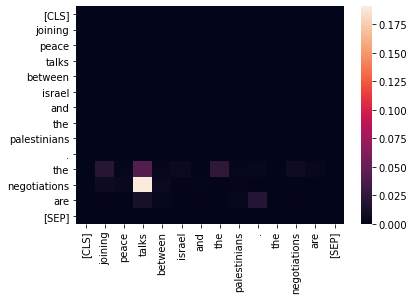

In [149]:
import seaborn as sns

# masked = mask_head_attention(all_attentions[1][0][0], 5)

masked = all_attentions[4][0][3]
sns.heatmap(pd.DataFrame(masked.detach().numpy()), xticklabels=tokens, yticklabels=tokens)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [85]:


all_attentions[0][0][0].shape

torch.Size([6, 6])

In [88]:
print(all_attentions[0][0][0])

tensor([[0.1026, 0.0997, 0.0956, 0.1244, 0.0844, 0.4932],
        [0.0633, 0.1611, 0.3864, 0.1180, 0.0865, 0.1846],
        [0.1441, 0.1253, 0.2658, 0.1160, 0.1213, 0.2274],
        [0.1957, 0.0996, 0.1707, 0.1396, 0.3126, 0.0818],
        [0.2198, 0.0870, 0.2279, 0.1586, 0.2211, 0.0856],
        [0.1995, 0.0836, 0.1982, 0.0864, 0.1425, 0.2898]],
       grad_fn=<SelectBackward>)


In [106]:
# all_attentions[0][0][0][0] = 0
all_attentions[0][0][0]

tensor([[0.1026, 0.0997, 0.0956, 0.1244, 0.0844, 0.0000],
        [0.0633, 0.1611, 0.3864, 0.1180, 0.0865, 0.0000],
        [0.1441, 0.1253, 0.2658, 0.1160, 0.1213, 0.0000],
        [0.1957, 0.0996, 0.1707, 0.1396, 0.3126, 0.0000],
        [0.2198, 0.0870, 0.2279, 0.1586, 0.2211, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<SelectBackward>)

### Extracting Attention Weights

From: https://huggingface.co/transformers/model_doc/bert.html#bertmodel

**attentions**: Tuple of torch.FloatTensor (one for each layer) of shape (batch_size, num_heads, sequence_length, sequence_length).

Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.

In [86]:
coref_head = all_attentions[4][0][3]

print(coref_head.shape)

# Look at the references for the two co-referent words:
print("\"Negotiations\" attention weights: \n{}".format("\n".join(["\t{}".format(t) for t in coref_head[-3].detach().numpy()])))

print("\n\"Talks\" attention weights: \n\t{}".format("\n".join(["\t{}".format(t) for t in coref_head[3].detach().numpy()])))

torch.Size([6, 6])
"Negotiations" attention weights: 
	0.011086337268352509
	0.0007816706201992929
	4.896883910987526e-05
	0.04245786741375923
	0.00029360520420596004
	0.9453315138816833

"Talks" attention weights: 
		0.011086337268352509
	0.0007816706201992929
	4.896883910987526e-05
	0.04245786741375923
	0.00029360520420596004
	0.9453315138816833


In [40]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min',
      jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

<IPython.core.display.Javascript object>

## Javascript Error?

If you get `Javascript Error: require is not defined`:

https://github.com/jessevig/bertviz/issues/53

In [6]:
sentence = "joining peace talks between Israel and the Palestinians. The negotiations are"

inputs = tokenizer.encode_plus(sentence, return_tensors='pt')
input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)    

all_hidden_states, all_attentions = model(input_ids)[-2:]

In [7]:
data = open("../data/greeneyes.txt").read()

In [8]:
data[:400]

'“All right, try to take it a little easy now, Arthur,” the gray-haired man said. “In the first place, if I know the Ellenbogens, they probably all hopped in a cab and went down to the Village for a couple of hours. All three of ’em’ll probably barge -”\n\n“I have a feeling she went to work on some bastard in the kitchen. I just have a feeling. She always starts necking some bastard in the kitchen wh'

In [9]:
inputs = tokenizer.encode_plus(data, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)    

2020-10-04 18:35:30,895 [37593] WARNING  transformers.tokenization_utils:675: [JupyterRequire] Token indices sequence length is longer than the specified maximum sequence length for this model (1352 > 512). Running this sequence through the model will result in indexing errors


In [26]:
attention_and_tokens_list = []

for i in range(10, 200, 20):
    
    # define lookback window of 30 tokens
    window_start = max(0, i - 5)
    
    # Reach into the IDs tensor and grab the slice we want
    token_ids_to_process = input_ids[0][window_start:i]
    
    # Go back and get the actual tokens that correspond to those IDs
    tokens = tokenizer.convert_ids_to_tokens(token_ids_to_process.tolist())
    
    # Run the IDs through the model (need to reshape back to 1xtokens tensor)
    attentions = model(token_ids_to_process.reshape(1, -1))[-1]
    
    print(attentions[0].shape)
    
    # Append the attention weights and the tokens to our list
    attention_and_tokens_list.append((attentions, tokens))
    

torch.Size([1, 12, 5, 5])
torch.Size([1, 12, 5, 5])
torch.Size([1, 12, 5, 5])
torch.Size([1, 12, 5, 5])
torch.Size([1, 12, 5, 5])
torch.Size([1, 12, 5, 5])
torch.Size([1, 12, 5, 5])
torch.Size([1, 12, 5, 5])
torch.Size([1, 12, 5, 5])
torch.Size([1, 12, 5, 5])


In [27]:
attentions, tokens = attention_and_tokens_list[0]

head_view(attentions, tokens)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
import pandas as pd
pd.DataFrame(attentions[0][0][0].detach().numpy())

,0,1,2,3,4
0,0.137770,0.192600,0.165594,0.183119,0.320917
1,0.301887,0.228522,0.188392,0.155371,0.125829
2,0.296434,0.277139,0.120039,0.173713,0.132675
3,0.289667,0.235305,0.247581,0.130056,0.097391
4,0.224634,0.224674,0.232941,0.165194,0.152557


In [19]:
attentions[0].shape

torch.Size([1, 12, 30, 30])